In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix

import numpy as np
import pandas as pd

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [4]:
raw_data = pd.read_csv("data/heart.csv")
original_data = raw_data.drop(columns=["target"])
training_labels = raw_data["target"]
raw_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=10, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [5]:
## Need to define a scaling function that ignores categorical values...?
# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.2)    

In [35]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                700       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total para

## Training an SVM

In [6]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
]

lsvc = LinearSVC()
clf_grid = Pipeline([
    ("scaler", StandardScaler()),
    ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
])

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC())
])

In [9]:
# X_train

In [7]:
%time clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

CPU times: user 8.76 ms, sys: 1.87 ms, total: 10.6 ms
Wall time: 16 ms
SVM Test Accuracy: 0.803


In [37]:
%time _score = cross_val_score(clf, X=X_train, y=y_train, cv=10)
print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

CPU times: user 7.78 ms, sys: 574 µs, total: 8.36 ms
Wall time: 7.9 ms
SVM Test Accuracy: 0.803
CPU times: user 112 ms, sys: 1.32 ms, total: 114 ms
Wall time: 114 ms
SVM CV Accuracy: 0.823(+/- 0.107)


In [38]:
%time clf_grid.fit(X_train, y_train)

CPU times: user 234 ms, sys: 54.5 ms, total: 288 ms
Wall time: 18.9 s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVMGrid',
                 GridSearchCV(cv=10, error_score='raise-deprecating',
                              estimator=LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                                                  verbos...
                                           'max_iter': [10000000],
                                           'penalty': ['l1', 'l2'],
   

In [56]:
grid = clf_grid.steps[1][1]
print(grid.best_params_)

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", LinearSVC(**grid.best_params_))
])

%time svm_clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

%time _score = cross_val_score(svm_clf, X=X_train, y=y_train, cv=10)
print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
CPU times: user 5.82 ms, sys: 753 µs, total: 6.58 ms
Wall time: 5.78 ms
SVM Test Accuracy: 0.787
CPU times: user 76.8 ms, sys: 1.26 ms, total: 78.1 ms
Wall time: 78.2 ms
SVM CV Accuracy: 0.852(+/- 0.130)


In [51]:
pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1)
pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.429, Acc:0.8644
Prediction Accuracy
25/25 [==============================] - 0s 22us/step
Scores on data set: loss=0.639 accuracy=0.7600
Fold Correct: 19
Running worker: 1
Fold: 1 -> Loss:0.402, Acc:0.8602
Prediction Accuracy
25/25 [==============================] - 0s 28us/step
Scores on data set: loss=0.433 accuracy=0.8400
Fold Correct: 21
Running worker: 2
Fold: 2 -> Loss:0.402, Acc:0.8739
Prediction Accuracy
24/24 [==============================] - 0s 27us/step
Scores on data set: loss=0.586 accuracy=0.7500
Fold Correct: 18
Running worker: 3
Fold: 3 -> Loss:0.409, Acc:0.8824
Prediction Accuracy
24/24 [==============================] - 0s 33us/step
Scores on data set: loss=0.555 accuracy=0.8333
Fold Correct: 20
Running worker: 4
Fold: 4 -> Loss:0.469, Acc:0.8613
Prediction Accuracy
24/24 [==============================] - 0s 26us/step
Scores on data set: loss=0.271 accuracy=0.9583
Fold Correct: 23
Running worker: 5
F

In [57]:
avg=sum(pipeline.correct_preds_bool_arr)/len(pipeline.correct_preds_bool_arr)
print("CV Avg:", avg)

CV Avg: 0.8223140495867769


Confusion matrix, without normalization
[[ 88  22]
 [ 21 111]]


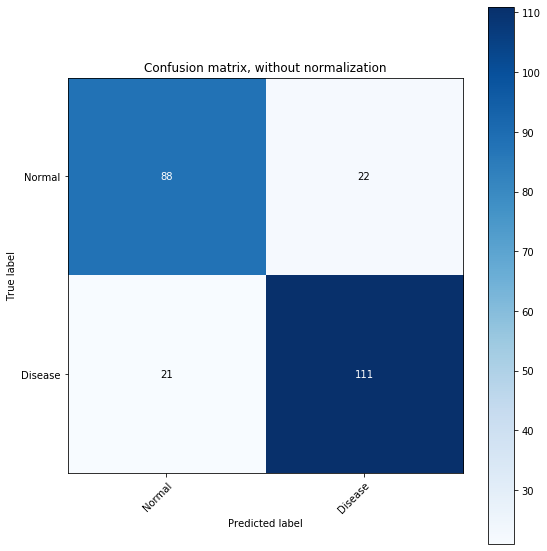

In [58]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

Normalized confusion matrix
[[0.8        0.2       ]
 [0.15909091 0.84090909]]


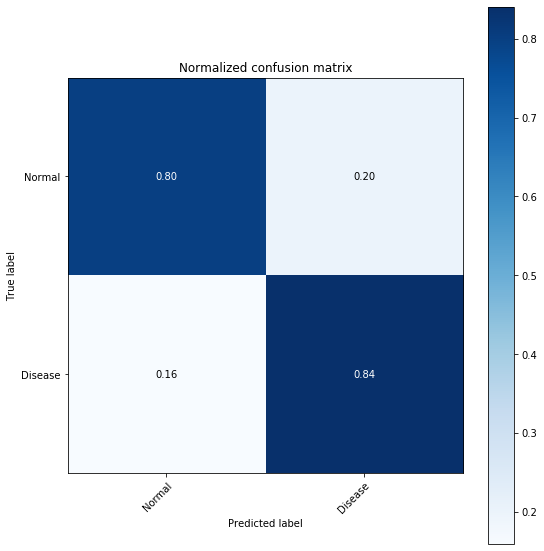

In [59]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]), normalize=True)

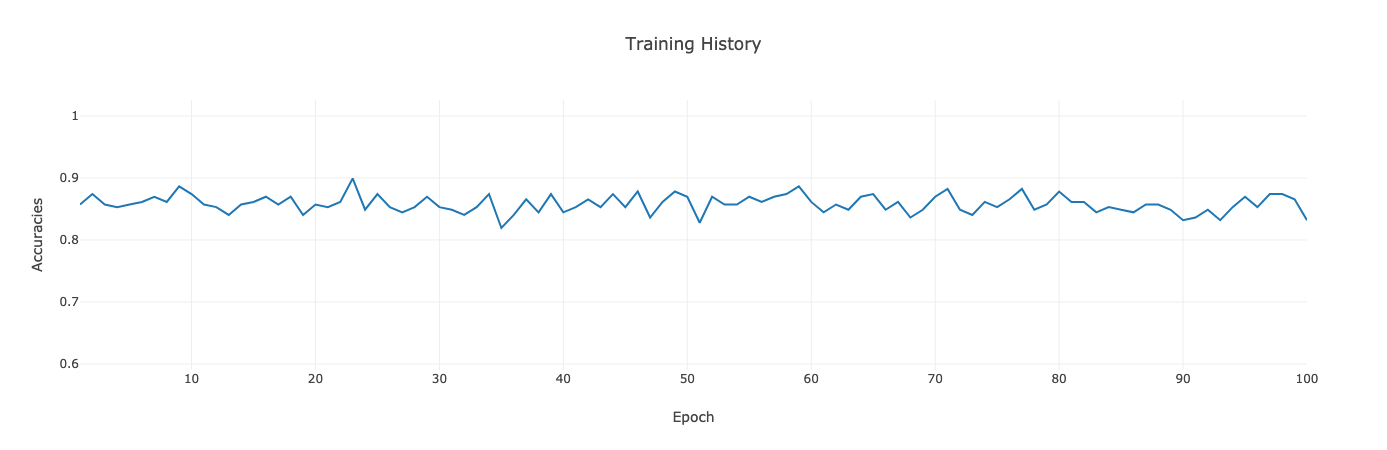

In [60]:
from plotly.offline import iplot
from plotly.offline import plot

accs = nn.history.history["acc"]
loss = nn.history.history["loss"]

accs_plot = go.Scatter(
    x=[x for x in range(1,len(accs)+1)],
    y=accs,
    mode="lines",
    name="line plot"
)

data = [accs_plot]

layout = go.Layout(
    title= "Training History",
    yaxis= {"title":"Accuracies"},
    xaxis={"title":"Epoch"}
)

fig = go.Figure(data=data, layout=layout)


iplot(fig)

In [61]:
min_cluster_sizes=range(3,20,1)
pipeline.train_clusterer(min_cluster_sizes=min_cluster_sizes, plot=False)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:725: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:734

Minimum Size:
Clusters                  5
Noise                     4
Silhouette                6
Halkidi                   3
Halkidi-Filtered Noise    3
Halkidi-Bounded Noise     3
dtype: int64


,Clusters,Noise,Silhouette,Halkidi,Halkidi-Filtered Noise,Halkidi-Bounded Noise
3,4,0.504505,-7.945541e-03,6.153894e-01,5.987835e-01,9.992927e-01
4,2,0.423423,2.365767e-02,9.533348e-01,1.210894e+00,1.297940e+00
5,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
6,2,0.873874,-1.421681e-01,2.545080e+00,1.482665e+00,2.174716e+00
7,2,0.846847,-1.226332e-01,1.481238e+00,1.452531e+00,2.071052e+00
8,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
9,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
10,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
11,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
12,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09


In [62]:
pd.Series(pipeline.clusterer.labels_).value_counts()

-1    56
 3    37
 2    10
 1     4
 0     4
dtype: int64

In [63]:
# Internally populates self.val_set_lrp
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!


In [64]:
pd.Series(cluster_labels).value_counts()

-1    31
dtype: int64

In [66]:
# Get 

## Plotting Testing LRP

In [67]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

correct_pred_labels = pipeline.train_set.labels.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr]
split_class = correct_pred_labels == pipeline.target_class
split_class_lrp = np.array(pipeline.lrp_results)[split_class]

lrp_data = np.clip(split_class_lrp, 0,None)
val_lrp = np.clip(pipeline.val_set_lrp, 0,None)

# s_lrp_data = MinMaxScaler().fit_transform(lrp_data)

In [68]:
labels = correct_pred_labels[split_class]
len(labels)

111

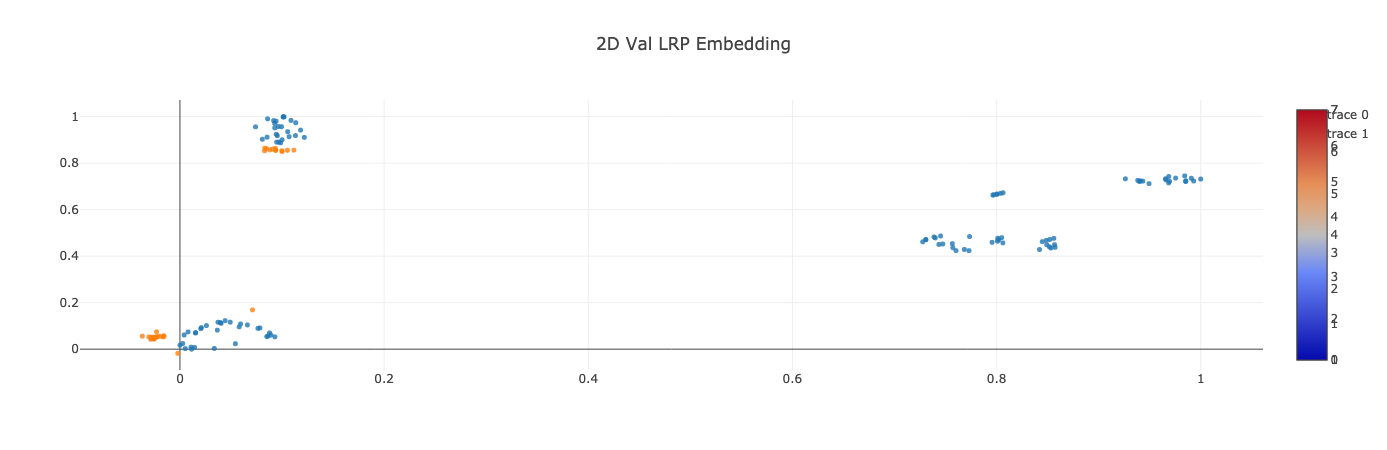

In [76]:
import umap
from matplotlib import pyplot as plt

embedding_pipeline_2d = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 2,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline_2d.fit(lrp_data)
embedding = embedding_pipeline_2d.transform(lrp_data)
val_embedding = embedding_pipeline_2d.transform(val_lrp)

emb2d = go.Scatter(
    x=embedding[:,0],
    y=embedding[:,1],
    mode="markers",
    marker=dict(
        size=5,
        colorscale='Rainbow',
        opacity=0.8,
        showscale=True
    )
)

val_emb2d = go.Scatter(
    x=val_embedding[:,0],
    y=val_embedding[:,1],
    mode="markers",
    marker=dict(
        size=5,
        colorscale='RdBu',
        opacity=0.8,
        showscale=True
    )
)

layout2d = go.Layout(
    title= "2D Val LRP Embedding"
)

data=[emb2d, val_emb2d]

fig = go.Figure(data=data, layout=layout2d)
iplot(fig)

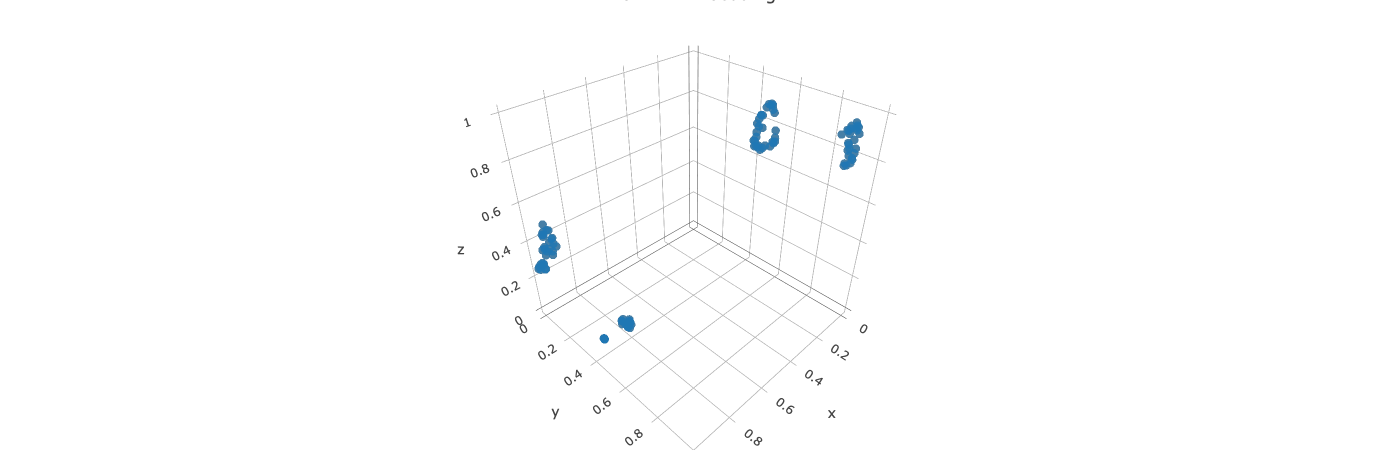

In [83]:
embedding_pipeline_3d = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline_3d.fit(lrp_data)

embedding = embedding_pipeline_3d.transform(lrp_data)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    marker=dict(
        size=5,
        colorscale="Rainbow",
        opacity=0.8
    )
)

layout = go.Layout(
    title= "Val LRP Embedding",
     margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=[emb3d], layout=layout)
iplot(fig, filename='lrp-val.html')

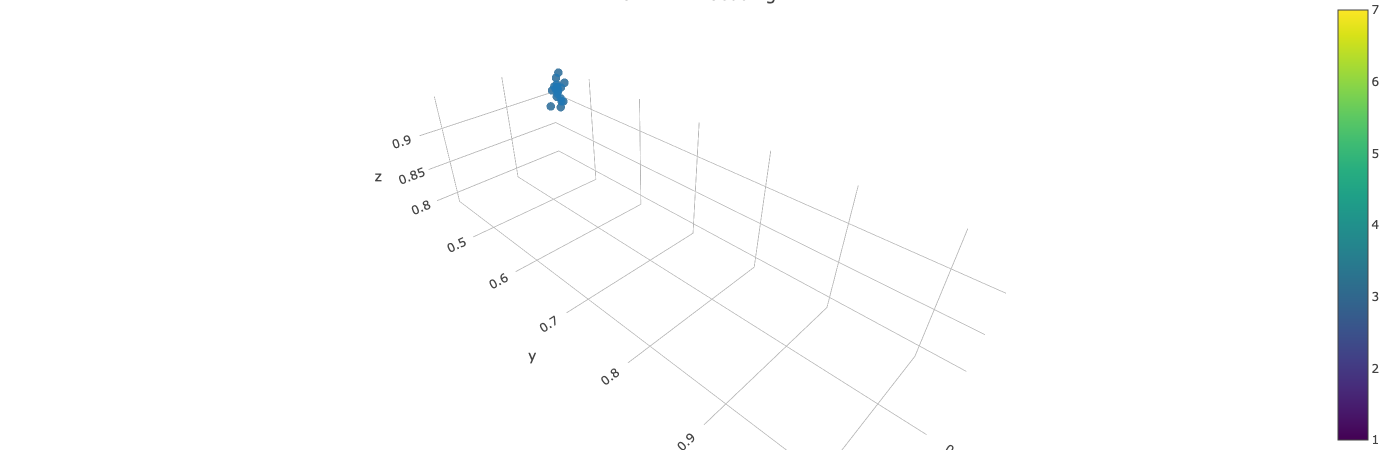

In [86]:
val_3d_embedding = embedding_pipeline_3d.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    mode="markers",
    marker=dict(
        size=5,
        colorscale='Viridis',
        opacity=0.8,
        showscale=True
    )
)

layout_val = go.Layout(
    title= "Val LRP Embedding",
     margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

data=[val_emb3d]

fig = go.Figure(data=data, layout=layout_val)
iplot(fig, filename='lrp-val.html')

## Using UMAP as a preprocessing step to either
   ### - Reduce dimenions to improvce HDBSCAN performance
   ### - Contract clusters on a manifold inside the original dimension

In [87]:
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(lrp_data)

lrp_embedding = embedding_pipeline.transform(lrp_data)
val_embedding = embedding_pipeline.transform(val_lrp)

## Hyper Parameter search for HDBSCAN

In [89]:
import hdbscan
from s_dbw import S_Dbw

ii32 = np.iinfo(np.int32)

plot=False        # FIXME: Assumes 2D data only
if plot:
    plt.close("Cluster Comparison") #1+len(cluster_sizes)
    fig, axs = plt.subplots(1+len(cluster_sizes), 1, figsize=(15,6*(+len(cluster_sizes))), num="Cluster Comparison")
    plt.title("Cluster Comparison")

    axs[0].scatter(*data.T, s=50, linewidth=0, c=labels, alpha=0.5, cmap="Set1")
    axs[0].set_title("Original Distribution")

_metrics = []
cluster_sizes = range(10,17)
data = lrp_embedding
min_samp_start = 10

for i,size in enumerate(cluster_sizes):
    min_samples = range(min_samp_start,size+1)

    for j,min_s in enumerate(min_samples):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size, min_samples=min_s)
        clusterer.fit(data)
        cluster_labels = clusterer.labels_

        ## Number of clusters in labels, ignoring noise if present.
        num_clusters = cluster_labels.max() + 1

    #     color_palette = sns.color_palette("bright", num_clusters)
    #     cluster_colors = [color_palette[x] if x >= 0
    #                     else (0, 0, 0)
    #                     for x in clusterer.labels_]
    #     cluster_member_colors = [sns.desaturate(x, p) for x, p in
    #                             zip(cluster_colors, clusterer.probabilities_)]

        # print(cluster_labels)
        noise, halkidi_s_Dbw, halkidi_ignore_noise, halkidi_bind = [ii32.max]*4

        noise = list(cluster_labels).count(-1)/len(cluster_labels)
#         print(size,min_s)
#         print(pd.Series(clusterer.labels_).value_counts())
        if num_clusters > 1:
            halkidi_s_Dbw = S_Dbw(data, cluster_labels, alg_noise="comb", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')

            halkidi_ignore_noise = S_Dbw(data, cluster_labels, alg_noise="filter", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')

            halkidi_bind = S_Dbw(data, cluster_labels, alg_noise="bind", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')


        _metrics.append([num_clusters,noise, halkidi_s_Dbw, halkidi_ignore_noise, halkidi_bind])

        if plot:
            axs[i+1].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
            axs[i+1].set_title("Minimum Cluster Size: {}".format(size))
            axs[i+1].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                    horizontalalignment='right', verticalalignment='top',
                    fontsize=14, transform=axs[i+1].transAxes)

    if plot:
        plt.tight_layout()
        plt.show()
        plt.savefig(self.FIGUREDIR+"cluster_perf_comp.png")
        plt.close("Cluster Comparison")

In [90]:
index  = [y for x in cluster_sizes for y in list(zip([x]*x,range(min_samp_start,x+1))) ]
scores = pd.DataFrame(_metrics, columns=["Clusters", "Noise","Halkidi", "Halkidi-Filtered Noise", "Halkidi-Bounded Noise"], index=index)
scores

,Clusters,Noise,Halkidi,Halkidi-Filtered Noise,Halkidi-Bounded Noise
"(10, 10)",4,0.0,0.125179,0.125179,0.125179
"(11, 10)",4,0.0,0.125179,0.125179,0.125179
"(11, 11)",4,0.0,0.125179,0.125179,0.125179
"(12, 10)",4,0.0,0.125179,0.125179,0.125179
"(12, 11)",4,0.0,0.125179,0.125179,0.125179
"(12, 12)",4,0.0,0.125179,0.125179,0.125179
"(13, 10)",4,0.0,0.125179,0.125179,0.125179
"(13, 11)",4,0.0,0.125179,0.125179,0.125179
"(13, 12)",4,0.0,0.125179,0.125179,0.125179
"(13, 13)",3,0.0,0.195005,0.195005,0.195005


In [91]:
scores.idxmin()

Clusters                  (13, 13)
Noise                     (10, 10)
Halkidi                   (10, 10)
Halkidi-Filtered Noise    (10, 10)
Halkidi-Bounded Noise     (10, 10)
dtype: object

In [92]:
msize, msamp = scores["Halkidi-Filtered Noise"].idxmin()

clusterer = hdbscan.HDBSCAN(min_cluster_size=msize, min_samples=msamp, prediction_data=True)
clusterer.fit(lrp_embedding)
pd.Series(clusterer.labels_).value_counts()

2    31
1    30
3    26
0    24
dtype: int64

## Plotting Validation LRP

In [94]:
cluster_labels, strengths = hdbscan.approximate_predict(clusterer, val_embedding)
pd.Series(cluster_labels).value_counts()

2    19
3    12
dtype: int64

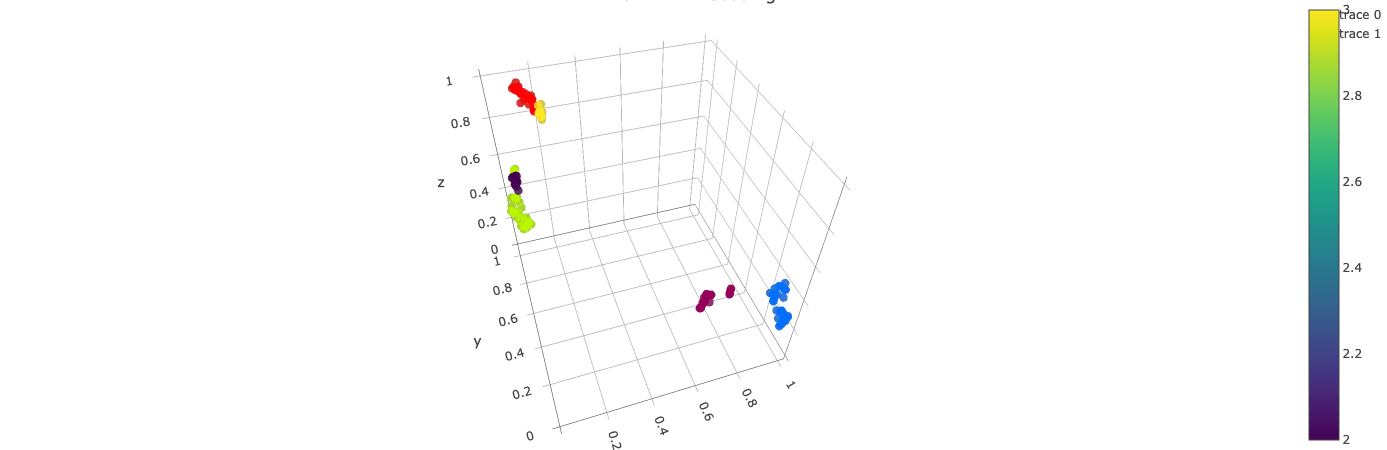

In [96]:
val_emb3d["marker"]["color"]=cluster_labels
val_emb3d["text"]=cluster_labels
data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-val.html')

# Performing Feature Reduction

In [99]:
def get_relevant_cols(df, thresh = 1e-2):

    all_above_thresh = (df < thresh).all(0) #Check if all values in columns satisfy the criteria
    max_above_thresh = (df.max() < thresh)
    quantile_above_thresh = (df.quantile(0.8) <= thresh)

    criteria = quantile_above_thresh
    irrelevant_cols = df.columns[criteria] 
    irrelevant_cols
    
    relevant_features_only = df.drop(columns = irrelevant_cols)
    
    return relevant_features_only

In [100]:
largest_cluster = pd.Series(cluster_labels).value_counts().idxmax()
largest_cluster

2

In [101]:
cluster_label = largest_cluster
val_clustered = pd.DataFrame(val_lrp[(cluster_labels == cluster_label)], columns = X_train.columns)

In [102]:
val_clustered.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,19.000000,19.000000,19.0,19.000000,19.000000,19.000000,19.000000,19.0,19.000000,19.0,19.000000,19.000000,19.000000
mean,0.354605,0.023729,0.0,0.023485,3.461334,0.001403,0.003546,0.0,0.004176,0.0,0.000460,0.002045,0.062604
std,0.369992,0.027438,0.0,0.034394,1.063176,0.002451,0.004413,0.0,0.012628,0.0,0.000463,0.008916,0.022396
min,0.000000,0.000000,0.0,0.000000,2.267742,0.000000,0.000000,0.0,0.000000,-0.0,0.000000,0.000000,0.027407
25%,0.017464,0.000000,0.0,0.000000,2.456086,0.000000,0.000000,0.0,0.000000,0.0,0.000093,0.000000,0.044143
50%,0.123880,0.000000,0.0,0.000000,3.419959,0.000000,0.000000,0.0,0.000000,0.0,0.000332,0.000000,0.065160
75%,0.654216,0.045943,0.0,0.037698,4.319009,0.001914,0.007607,0.0,0.000000,0.0,0.000729,0.000000,0.078371
max,0.961432,0.075201,0.0,0.107179,5.543185,0.006165,0.012857,0.0,0.044874,-0.0,0.001513,0.038862,0.105355


In [103]:
# thresh = min(val_clustered.describe().loc["75%"])

In [104]:
reduced_val = get_relevant_cols(val_clustered, thresh=0)
reduced_val.head()

,age,sex,trestbps,chol,fbs,restecg,slope,thal
0,0.000000,0.000000,0.000000,2.322126,0.005711,0.005198,0.000000,0.052456
1,0.830806,0.000000,0.080656,4.532400,0.000000,0.000000,0.000101,0.087665
2,0.320888,0.059588,0.000000,3.843218,0.000000,0.009353,0.000000,0.080574
3,0.041826,0.000000,0.000000,2.604373,0.000000,0.000000,0.000423,0.044015
4,0.000000,0.000000,0.000000,2.267742,0.003829,0.000000,0.001513,0.031707


## Using reduced features for retraining

> **Only values from the same cluster can be retrained**

In [105]:
feature_idxs = reduced_val.columns
feature_idxs

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'slope', 'thal'], dtype='object')

In [44]:
# ~target_samples

In [106]:
# Ideally only get samples belonging to subclusters

# Separating Control from Target
reindexer = pipeline.testing_idxs
correct_preds = pipeline.correct_preds_bool_arr

target_samples = y_train.iloc[reindexer][correct_preds] == pipeline.target_class
control_samples = ~target_samples

tsamples = X_train.iloc[reindexer][correct_preds][target_samples]
tlabels = y_train.iloc[reindexer][correct_preds][target_samples]

tsamples = tsamples[(clusterer.labels_ == cluster_label)]
tlabels = tlabels[(clusterer.labels_ == cluster_label)]


csamples = X_train.iloc[reindexer][correct_preds][control_samples]
csamples = csamples[:len(tsamples)]

clabels = y_train.iloc[reindexer][correct_preds][control_samples]
clabels = clabels[:len(tsamples)]


#Now stack it with control values of same size.. 
X_train_sc = pd.concat([csamples, tsamples], axis="index")
y_train_sc = pd.concat([clabels, tlabels], axis="index")

In [107]:
# All the samples from X_valid are used for now...
X_valid_red = X_valid[feature_idxs]

nn = build_dnn(num_features=X_train_sc.shape[1])
# nn.summary()

### Baseline CN vs Subcluster

> **Reusing the same network architecture may not be valid as the samples are already biased towards it**

In [121]:
# %time clf.fit(X_train_sc, y_train_sc)
# print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

%time _score = cross_val_score(clf, X=X_train_sc, y=y_train_sc, cv=10)
print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

CPU times: user 65 ms, sys: 1.96 ms, total: 67 ms
Wall time: 66.2 ms
SVM CV Accuracy: 0.971(+/- 0.118)


In [122]:
%time clf_grid.fit(X_train_red, y_train_sc)

CPU times: user 164 ms, sys: 5.27 ms, total: 169 ms
Wall time: 1.55 s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVMGrid',
                 GridSearchCV(cv=10, error_score='raise-deprecating',
                              estimator=LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                                                  verbos...
                                           'max_iter': [10000000],
                                           'penalty': ['l1', 'l2'],
   

In [124]:
grid = clf_grid.steps[1][1]
print(grid.best_params_)

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", LinearSVC(**grid.best_params_))
])

# %time svm_clf.fit(X_train, y_train)
# print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

%time _score = cross_val_score(svm_clf, X=X_train_sc, y=y_train_sc, cv=10)
print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
CPU times: user 63.4 ms, sys: 1.62 ms, total: 65 ms
Wall time: 64.2 ms
SVM CV Accuracy: 0.971(+/- 0.118)


## Reduced Features

In [115]:
X_train_red = X_train_sc[feature_idxs]
print(X_train_red.shape)
X_train_red.head()

(62, 8)


,age,sex,trestbps,chol,fbs,restecg,slope,thal
199,65,1,110,248,0,0,2,1
175,40,1,110,167,0,0,1,3
234,70,1,130,322,0,0,1,2
221,55,1,140,217,0,1,0,3
176,60,1,117,230,1,1,2,3


In [127]:
%time _score = cross_val_score(clf, X=X_train_red, y=y_train_sc, cv=10)
print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

CPU times: user 57.5 ms, sys: 1.55 ms, total: 59 ms
Wall time: 57.7 ms
SVM CV Accuracy: 0.675(+/- 0.425)


In [128]:
%time clf_grid.fit(X_train_red, y_train_sc)

CPU times: user 237 ms, sys: 5.61 ms, total: 242 ms
Wall time: 1.68 s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVMGrid',
                 GridSearchCV(cv=10, error_score='raise-deprecating',
                              estimator=LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                                                  verbos...
                                           'max_iter': [10000000],
                                           'penalty': ['l1', 'l2'],
   

In [129]:
grid = clf_grid.steps[1][1]
print(grid.best_params_)

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", LinearSVC(**grid.best_params_))
])

# %time svm_clf.fit(X_train, y_train)
# print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

%time _score = cross_val_score(svm_clf, X=X_train_red, y=y_train_sc, cv=10)
print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
CPU times: user 57.2 ms, sys: 2.15 ms, total: 59.3 ms
Wall time: 57.6 ms
SVM CV Accuracy: 0.775(+/- 0.334)
